dataset: https://www.kaggle.com/c/titanic

Python3.7.6

In [1]:
import pandas as pd  

data=pd.read_csv('./data/train.csv')  

data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [2]:
data.describe()  

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
#剔除变量  

data.drop(['PassengerId','Ticket'],axis=1,inplace=True)  

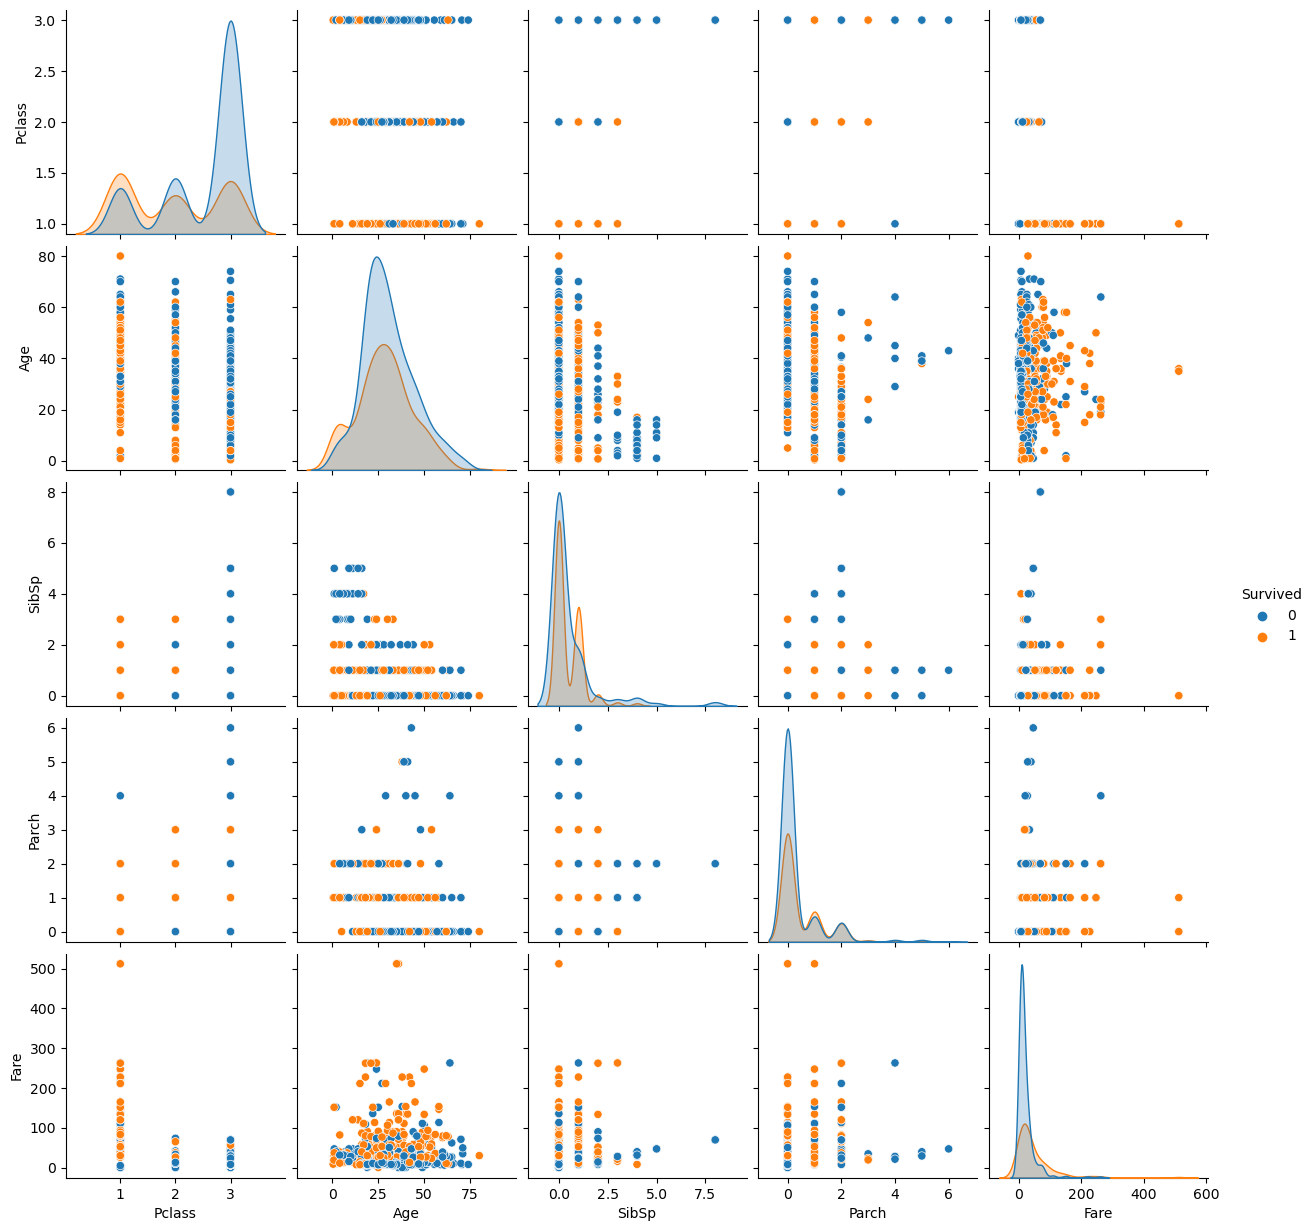

In [4]:
import seaborn as sns
sns.pairplot(data, hue="Survived")

In [5]:
#补全Embarked变量  

data.loc[data.Embarked.isnull(),'Embarked']='S'  

#one-hot编码  

from sklearn.preprocessing import OneHotEncoder  

from sklearn.preprocessing import LabelEncoder  

#ohe_pclass=OneHotEncoder(sparse=False).fit(data[['Pclass']])  

#Pclass_ohe=ohe_pclass.transform(data[['Pclass']])  

le_sex=LabelEncoder().fit(data['Sex'])  

Sex_label=le_sex.transform(data['Sex'])  

ohe_sex=OneHotEncoder(sparse=False).fit(Sex_label.reshape(-1,1))  

Sex_ohe=ohe_sex.transform(Sex_label.reshape(-1,1))  

le_embarked=LabelEncoder().fit(data['Embarked'])  

Embarked_label=le_embarked.transform(data['Embarked'])  

ohe_embarked=OneHotEncoder(sparse=False).fit(Embarked_label.reshape(-1,1))  

Embarked_ohe=ohe_embarked.transform(Embarked_label.reshape(-1,1)) 

In [6]:
def replace_name(x):  
    if 'Mrs' in x:  
       return 'Mrs'  
    elif 'Mr' in x:  
        return 'Mr'  
    else:  
        return 'Miss'  

In [7]:
data['Name']=data['Name'].map(lambda x:replace_name(x))  
le_name=LabelEncoder().fit(data['Name'])  
Name_label=le_name.transform(data['Name'])  
ohe_name=OneHotEncoder(sparse=False).fit(Name_label.reshape(-1,1))  
Name_ohe=ohe_name.transform(Name_label.reshape(-1,1))  
data['Sex_0']=Sex_ohe[:,0]  
data['Sex_1']=Sex_ohe[:,1]  
data['Embarked_0']=Embarked_ohe[:,0]  
data['Embarked_1']=Embarked_ohe[:,1]  
data['Embarked_2']=Embarked_ohe[:,2]  
data['Name_0']=Name_ohe[:,0]  
data['Name_1']=Name_ohe[:,1]  
data['Name_2']=Name_ohe[:,2]  

In [8]:
#归一化处理  

from sklearn.preprocessing import StandardScaler  
Pclass_scale=StandardScaler().fit(data['Pclass'].values.reshape(-1,1))  
data['Pclass_scaled']=StandardScaler().fit_transform(data['Pclass'].values.reshape(-1,1),Pclass_scale)  
Fare_scale=StandardScaler().fit(data['Fare'].values.reshape(-1,1))  
data['Fare_scaled']=StandardScaler().fit_transform(data['Fare'].values.reshape(-1,1),Fare_scale)  
SibSp_scale=StandardScaler().fit(data['SibSp'].values.reshape(-1,1))  
data['SibSp_scaled']=StandardScaler().fit_transform(data['SibSp'].values.reshape(-1,1),SibSp_scale)  
Parch_scale=StandardScaler().fit(data['Parch'].values.reshape(-1,1))  
data['Parch_scaled']=StandardScaler().fit_transform(data['Parch'].values.reshape(-1,1),Parch_scale)  

In [9]:
#预测年纪并补全  

from sklearn.ensemble import RandomForestRegressor  

def set_missing_age(data):  

    train=data[['Age','SibSp_scaled','Parch_scaled','Name_0','Name_1','Name_2','Sex_0','Sex_1']]  

    known_age=train[train.Age.notnull()].values

    unknown_age=train[train.Age.isnull()].values

    y=known_age[:,0]  

    x=known_age[:,1:]  

    rf=RandomForestRegressor(random_state=0,n_estimators=200,n_jobs=-1)  

    rf.fit(x,y)  

    print(rf.score(x,y))

    predictage=rf.predict(unknown_age[:,1:])  

    data.loc[data.Age.isnull(),'Age']=predictage  

    return data,rf  

In [10]:
data,rf=set_missing_age(data)  

Age_scale=StandardScaler().fit(data['Age'].values.reshape(-1,1))  

data['Age_scaled']=StandardScaler().fit_transform(data['Age'].values.reshape(-1,1),Age_scale)  

train_x=data[['Sex_0','Sex_1','Embarked_0','Embarked_1','Embarked_2','Name_0','Name_1','Name_2','Pclass_scaled','Age_scaled','Fare_scaled']].values

train_y=data['Survived'].values

0.3594343141374696


In [11]:
#模型构造  

from sklearn.model_selection import train_test_split  

from sklearn.linear_model import LogisticRegression  

x_tr,x_te,y_tr,y_te=train_test_split(train_x,train_y,test_size=0.3,random_state=0)  

lr=LogisticRegression(C=1.0,tol=1e-6)  

lr.fit(x_tr,y_tr)  

print(lr.score(x_te,y_te))  

from sklearn.svm import SVC  

svc=SVC(C=2, kernel='rbf', decision_function_shape='ovo')  

svc.fit(x_tr,y_tr)  

print(svc.score(x_te,y_te))  

from sklearn.ensemble import RandomForestClassifier  

randomf=RandomForestClassifier(n_estimators=500,max_depth=5,random_state=0)  

randomf.fit(x_tr,y_tr)  

print(randomf.score(x_te,y_te))  

from sklearn.ensemble import GradientBoostingClassifier  

gdbt=GradientBoostingClassifier(n_estimators=600,max_depth=5,random_state=0)  

gdbt.fit(x_tr,y_tr)  

print(gdbt.score(x_te,y_te)) 

0.7835820895522388
0.8246268656716418
0.8246268656716418
0.8134328358208955


In [12]:
#模型构造  

from sklearn.model_selection import train_test_split  

from sklearn.linear_model import LogisticRegression  

x_tr,x_te,y_tr,y_te=train_test_split(train_x,train_y,test_size=0.3,random_state=1)  

lr=LogisticRegression(C=1.0,tol=1e-6)  

lr.fit(x_tr,y_tr)  

print(lr.score(x_te,y_te))  

from sklearn.svm import SVC  

svc=SVC(C=2, kernel='rbf', decision_function_shape='ovo')  

svc.fit(x_tr,y_tr)  

print(svc.score(x_te,y_te))  

from sklearn.ensemble import RandomForestClassifier  

randomf=RandomForestClassifier(n_estimators=500,max_depth=5,random_state=1)  

randomf.fit(x_tr,y_tr)  

print(randomf.score(x_te,y_te))  

from sklearn.ensemble import GradientBoostingClassifier  

gdbt=GradientBoostingClassifier(n_estimators=600,max_depth=5,random_state=1)  

gdbt.fit(x_tr,y_tr)  

print(gdbt.score(x_te,y_te)) 

0.7686567164179104
0.7873134328358209
0.7873134328358209
0.7686567164179104


In [12]:
#预测数据  
import numpy as np

data_test=pd.read_csv('./data/test.csv')  

data_test.drop(['Ticket'],axis=1,inplace=True)  

data_test.loc[data_test.Embarked.isnull(),'Embarked']='S'  

Sex_label_test=le_sex.transform(data_test['Sex'])  

Sex_ohe_test=ohe_sex.transform(Sex_label_test.reshape(-1,1))  

Embarked_label_test=le_embarked.transform(data_test['Embarked'])  

Embarked_ohe_test=ohe_embarked.transform(Embarked_label_test.reshape(-1,1))  

data_test['Name']=data_test['Name'].map(lambda x:replace_name(x))  

Name_label_test=le_name.transform(data_test['Name'])  

Name_ohe_test=ohe_name.transform(Name_label_test.reshape(-1,1))  

data_test['Sex_0']=Sex_ohe_test[:,0]  

data_test['Sex_1']=Sex_ohe_test[:,1]  

data_test['Embarked_0']=Embarked_ohe_test[:,0]  

data_test['Embarked_1']=Embarked_ohe_test[:,1]  

data_test['Embarked_2']=Embarked_ohe_test[:,2]  

data_test['Name_0']=Name_ohe_test[:,0]  

data_test['Name_1']=Name_ohe_test[:,1]  

data_test['Name_2']=Name_ohe_test[:,2]  

data_test['Pclass_scaled']=StandardScaler().fit_transform(data_test['Pclass'].values.reshape(-1,1),Pclass_scale)  

data_test.loc[data_test.Fare.isnull(),'Fare']=0  

data_test['Fare_scaled']=StandardScaler().fit_transform(data_test['Fare'].values.reshape(-1,1),Fare_scale)  

data_test['SibSp_scaled']=StandardScaler().fit_transform(data_test['SibSp'].values.reshape(-1,1),SibSp_scale)  

data_test['Parch_scaled']=StandardScaler().fit_transform(data_test['Parch'].values.reshape(-1,1),Parch_scale)  

train_test=data_test[['Age','SibSp_scaled','Parch_scaled','Name_0','Name_1','Name_2','Sex_0','Sex_1']]  

unknown_age_test=train_test[train_test.Age.isnull()].values

x_test=unknown_age_test[:,1:]  

predictage=rf.predict(x_test)  

data_test.loc[data_test.Age.isnull(),'Age']=predictage  

data_test['Age_scaled']=StandardScaler().fit_transform(data_test['Age'].values.reshape(-1,1),Age_scale)  

test_x=data_test[['Sex_0','Sex_1','Embarked_0','Embarked_1','Embarked_2','Name_0','Name_1','Name_2','Pclass_scaled','Age_scaled','Fare_scaled']].values 

predictions=svc.predict(test_x).astype(np.int32)  

result=pd.DataFrame({'PassengerId':data_test['PassengerId'].values,'Survived':predictions})  

result.to_csv('svc.csv',index=False)  

In [13]:
from sklearn.ensemble import VotingClassifier  

model=VotingClassifier(estimators=[('lr',lr),('svc',svc),('rf',randomf),('GDBT',gdbt)],voting='hard',weights=[0.5,1.5,0.6,0.6])  

model.fit(x_tr,y_tr)  

print(model.score(x_te,y_te))

0.8246268656716418


https://www.leiphone.com/category/yanxishe/XdTHyRfvacQjaxEz.html

https://blog.csdn.net/sinat_22594309/article/details/68951145

a nice notebook about this dataset: https://github.com/agconti/kaggle-titanic/blob/master/Titanic.ipynb